Import & StatType Class Definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
import matplotlib.cm as cm
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

Script Parameters

In [2]:
DEBUG = True

simName = "MMS_MITM_Wired"

rep = 30
simTimeLimit = 120
numClients = 1
numServers = 2

relPath = "../results/"

mpl.rcParams['figure.dpi'] = 300


In [3]:
fileNamesSca = []
fileNamesVec = []

cliMeasNames = [("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR), ("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]

for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


['../results/MMS_MITM_Wired-#0.sca', '../results/MMS_MITM_Wired-#1.sca', '../results/MMS_MITM_Wired-#2.sca', '../results/MMS_MITM_Wired-#3.sca', '../results/MMS_MITM_Wired-#4.sca', '../results/MMS_MITM_Wired-#5.sca', '../results/MMS_MITM_Wired-#6.sca', '../results/MMS_MITM_Wired-#7.sca', '../results/MMS_MITM_Wired-#8.sca', '../results/MMS_MITM_Wired-#9.sca', '../results/MMS_MITM_Wired-#10.sca', '../results/MMS_MITM_Wired-#11.sca', '../results/MMS_MITM_Wired-#12.sca', '../results/MMS_MITM_Wired-#13.sca', '../results/MMS_MITM_Wired-#14.sca', '../results/MMS_MITM_Wired-#15.sca', '../results/MMS_MITM_Wired-#16.sca', '../results/MMS_MITM_Wired-#17.sca', '../results/MMS_MITM_Wired-#18.sca', '../results/MMS_MITM_Wired-#19.sca', '../results/MMS_MITM_Wired-#20.sca', '../results/MMS_MITM_Wired-#21.sca', '../results/MMS_MITM_Wired-#22.sca', '../results/MMS_MITM_Wired-#23.sca', '../results/MMS_MITM_Wired-#24.sca', '../results/MMS_MITM_Wired-#25.sca', '../results/MMS_MITM_Wired-#26.sca', '../result

Function to create the statistics filter

In [4]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [5]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

name =~ "*readResponseReceivedTime:vector" OR name =~ "*commandResponseReceivedTime:vector" OR name =~ "*measureReceivedAmount:vector" OR name =~ "*readSent:count" OR name =~ "*commandSent:count" OR name =~ "*readResponse:count" OR name =~ "*commandResponse:count" OR name =~ "*readResponseTimeout:count" OR name =~ "*commandResponseTimeout:count" OR name =~ "*measureBlock:count" OR name =~ "*measureCompromised:count" OR name =~ "*readRequestBlock:count" OR name =~ "*readRequestCompromised:count" OR name =~ "*commandRequestBlock:count" OR name =~ "*commandRequestCompromised:count" OR name =~ "*readResponseBlock:count" OR name =~ "*readResponseCompromised:count" OR name =~ "*commandResponseBlock:count" OR name =~ "*commandResponseCompromised:count"


Plot client measures for each client aggregating all the repetitions 

In [6]:
def plotBoxWiskerSca(measNames, numClients, numServers, title = "", cli = "client"):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(17*numClients)
    fig.set_figwidth(22)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                 
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            if numClients != 1: 
                box.boxplot(ax=axes[i][j], grid=False, rot=90)
                axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                box.boxplot(ax=axes[j], grid=False, rot=90)
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
    return outVec

In [7]:
def plotBoxWiskerVec(numClients, numServers, title = "", cli = "client", vecMeasName = "measureReceivedAmount", numRanges = 0):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(12*numClients)
    fig.set_figwidth(25)
    
    ranges = list()
    if numRanges != 0:
        incr = simTimeLimit/numRanges
        nxt = 0
        while nxt+incr <= 120:
            ranges.append((nxt, nxt + incr))
            nxt += incr
    if DEBUG:
        print(ranges)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            if numRanges == 0:   
                box = None
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    if box is None:
                        box = pd.DataFrame(columns=vecTime)
                    box.loc[rowNum] = vecValue.tolist()
                    rowNum += 1   
                                    
                box = box.replace(np.nan, 0)
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(ax=axes[j], grid=False, rot=90)
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                box = pd.DataFrame(columns=["value", "ranges"])
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    for val, time in zip(vecValue, vecTime):    
                        for rang in ranges:
                            if time > rang[0] and time <= rang[1]:
                                box.loc[rowNum] = list((val, rang))
                                rowNum += 1
                                break   
                                    
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                if numClients != 1:
                    box.boxplot(ax=axes[i][j], column="value", by="ranges", grid=False, rot=90)
                    axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
                else:
                    box.boxplot(ax=axes[j], column="value", by="ranges", grid=False, rot=90)
                    axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')                    
    return outVec

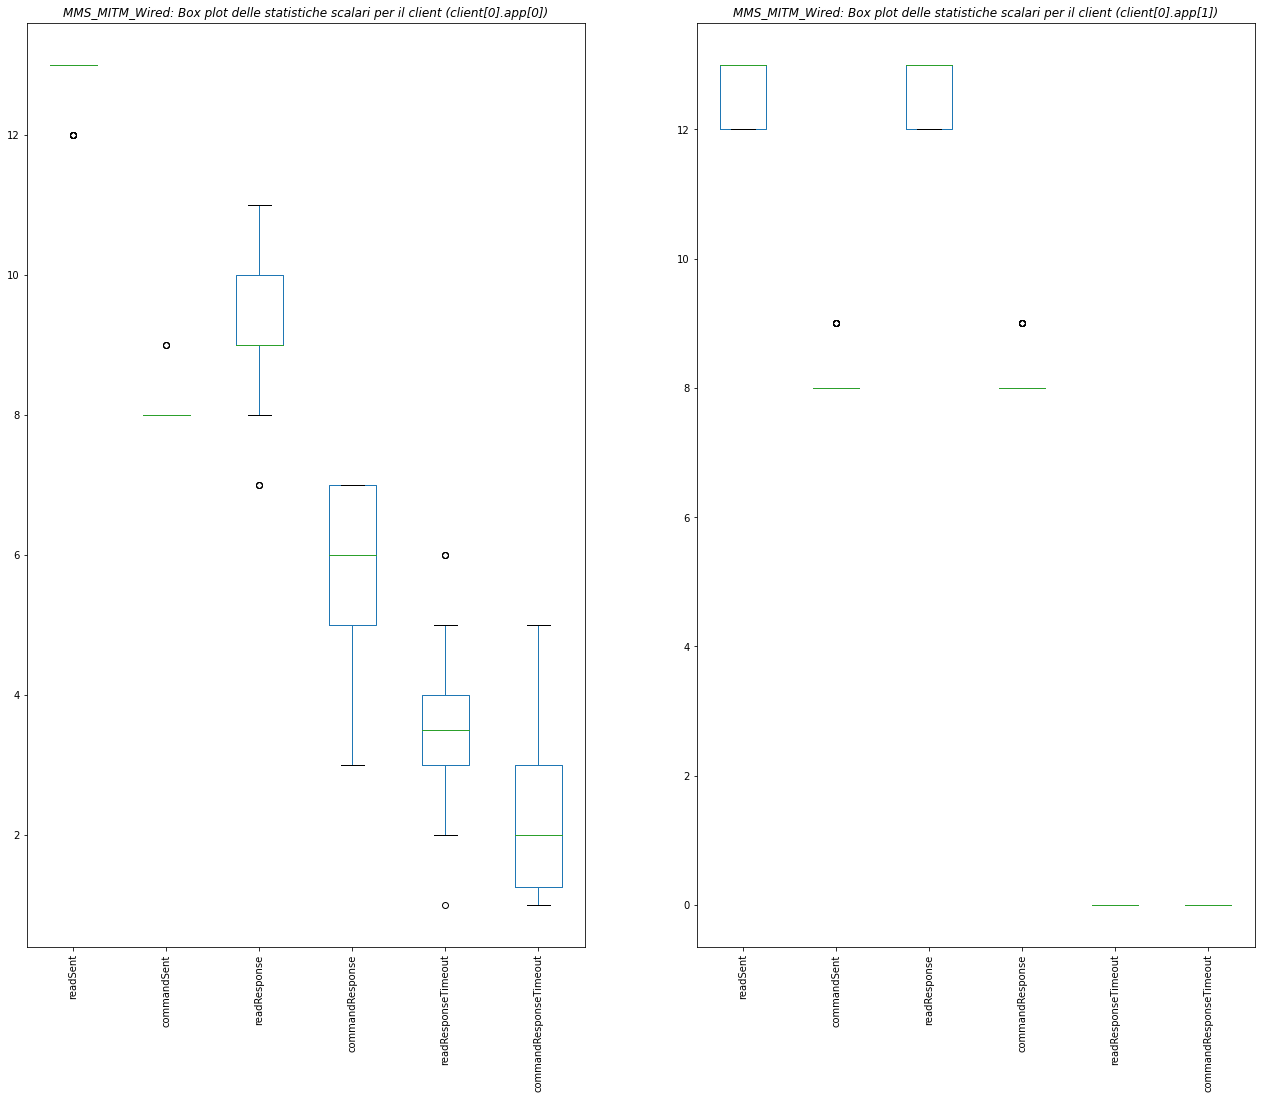

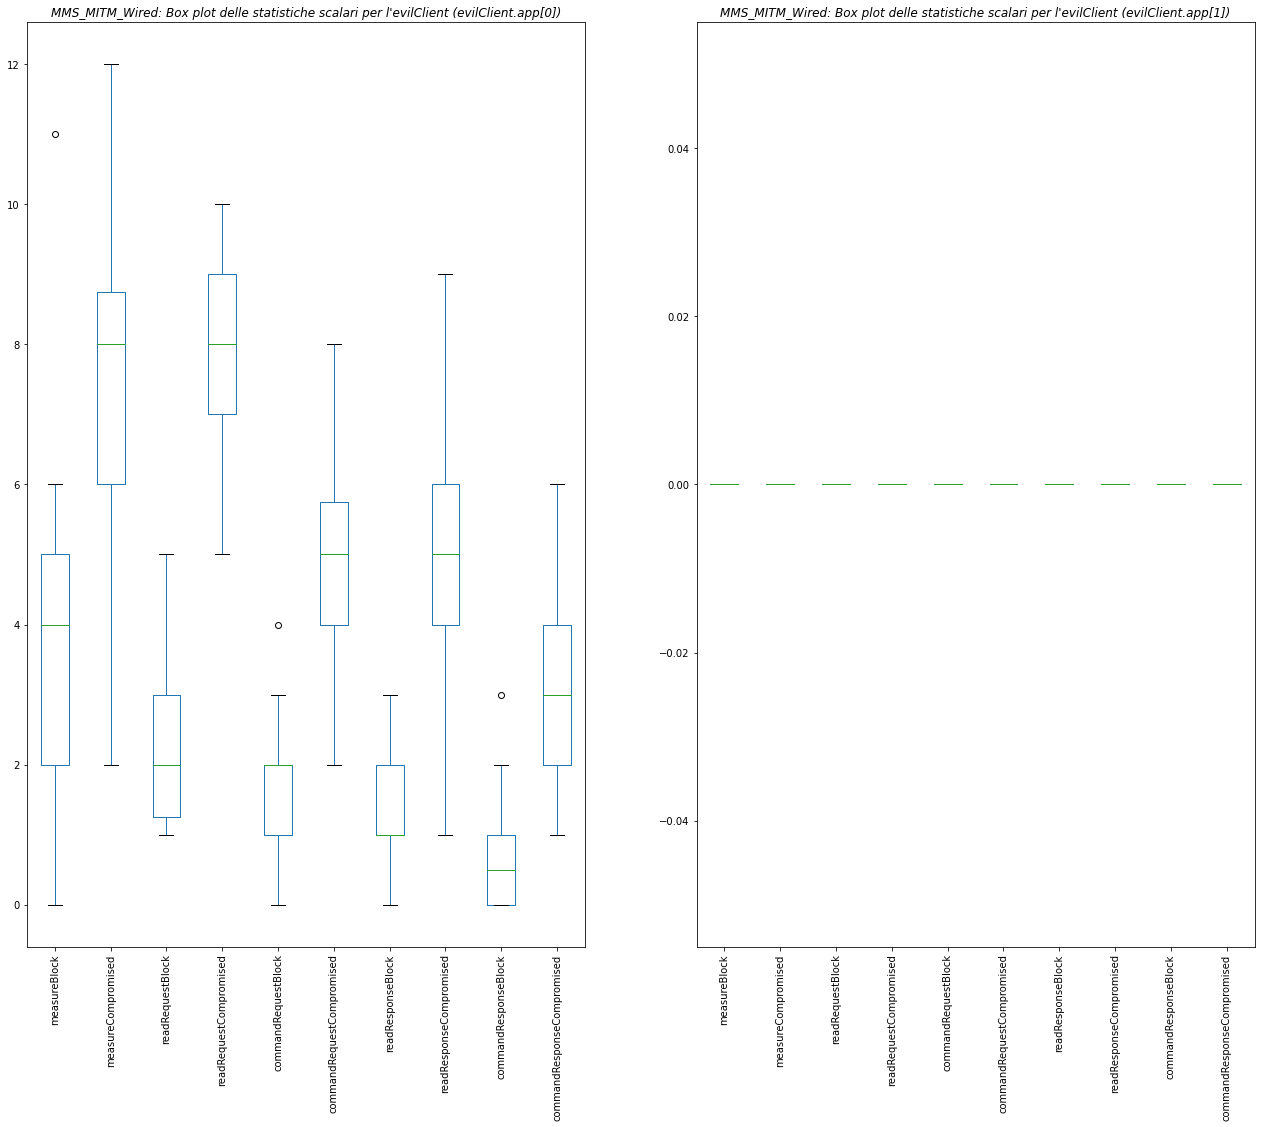

In [8]:
cliScaDfList = plotBoxWiskerSca(cliMeasNames, numClients, numServers, title=simName + ": Box plot delle statistiche scalari per il client")
evilScaDfList = plotBoxWiskerSca(evilMeasNames, 1, numServers, cli="evilClient", title=simName + ": Box plot delle statistiche scalari per l'evilClient")

Scatter Matrices for clients

## Data description for client[0].app[0] ##
        readSent  commandSent  readResponse  commandResponse  \
count  30.000000    30.000000     30.000000        30.000000   
mean   12.766667     8.100000      9.200000         5.833333   
std     0.430183     0.305129      1.126484         1.053183   
min    12.000000     8.000000      7.000000         3.000000   
25%    13.000000     8.000000      9.000000         5.000000   
50%    13.000000     8.000000      9.000000         6.000000   
75%    13.000000     8.000000     10.000000         7.000000   
max    13.000000     9.000000     11.000000         7.000000   

       readResponseTimeout  commandResponseTimeout  
count            30.000000               30.000000  
mean              3.500000                2.266667  
std               1.224745                1.080655  
min               1.000000                1.000000  
25%               3.000000                1.250000  
50%               3.500000                2.000000  
75%     

/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


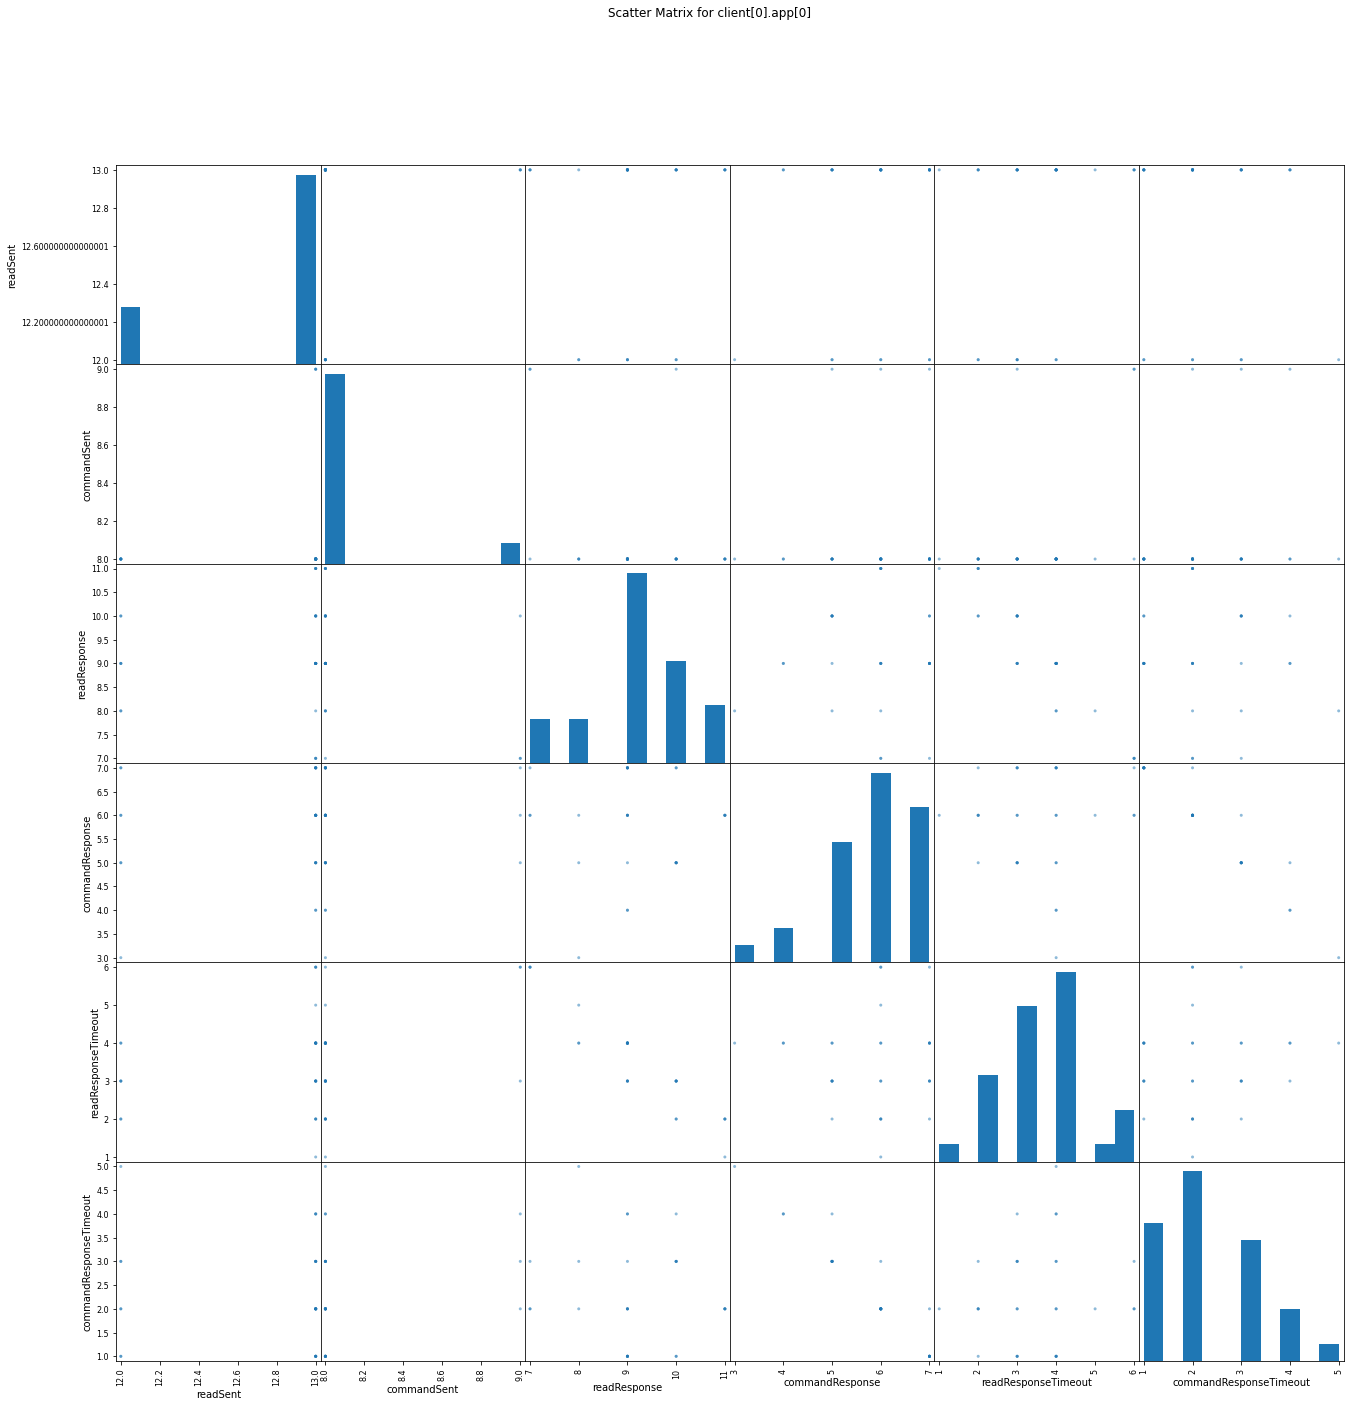

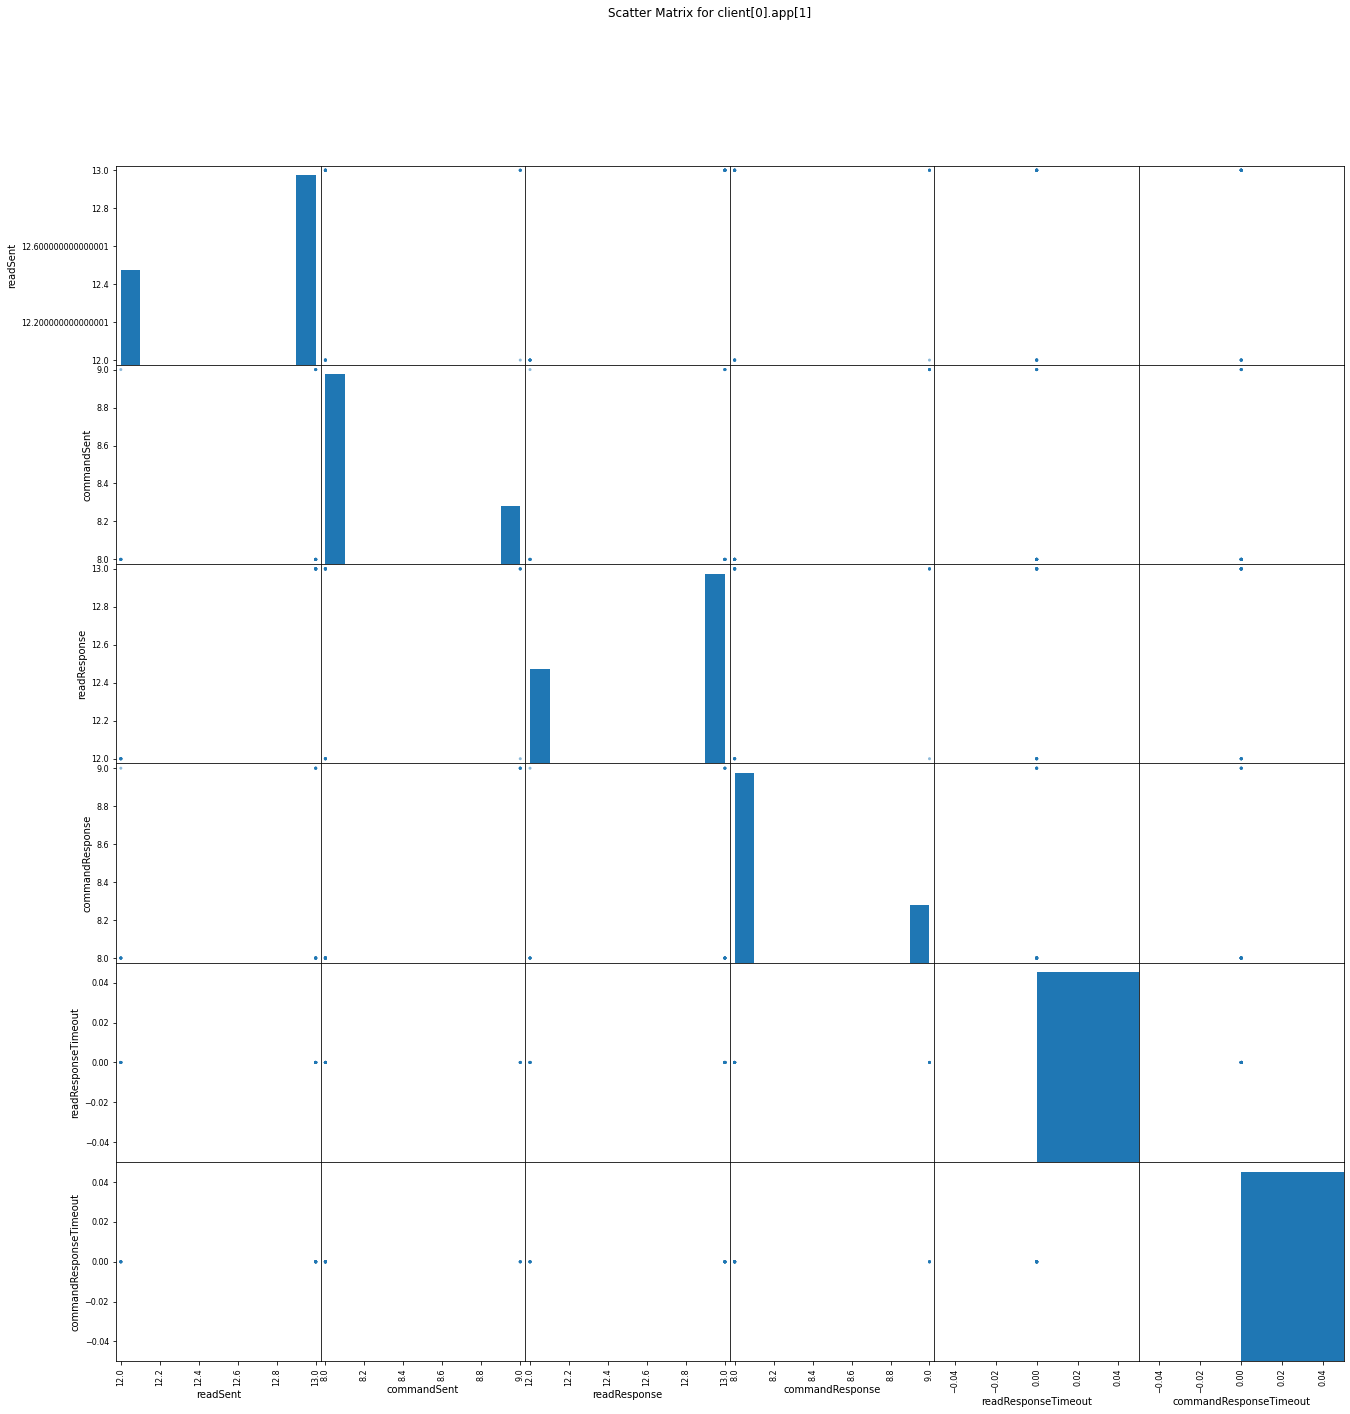

In [9]:
for i in range(numClients):
    for j in range(numServers):
        df = cliScaDfList[(i+1)*j]
        print("## Data description for client[" + str(i) + "].app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        pd.plotting.scatter_matrix(df, figsize=(22,22))
        plt.suptitle("Scatter Matrix for client[" + str(i) + "].app[" + str(j) + "]")


Scatter matrice for the evilClient

## Data description for evilClient.app[0] ##
       measureBlock  measureCompromised  readRequestBlock  \
count     30.000000           30.000000         30.000000   
mean       3.800000            7.566667          2.366667   
std        2.006885            1.959650          1.129032   
min        0.000000            2.000000          1.000000   
25%        2.000000            6.000000          1.250000   
50%        4.000000            8.000000          2.000000   
75%        5.000000            8.750000          3.000000   
max       11.000000           12.000000          5.000000   

       readRequestCompromised  commandRequestBlock  commandRequestCompromised  \
count               30.000000            30.000000                  30.000000   
mean                 7.833333             1.633333                   4.633333   
std                  1.234094             1.033352                   1.449931   
min                  5.000000             0.000000                   2.000000   


/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:115: RuntimeWarning: invalid value encountered in divide
  adj = (locs - lim1[0]) / (lim1[1] - lim1[0])


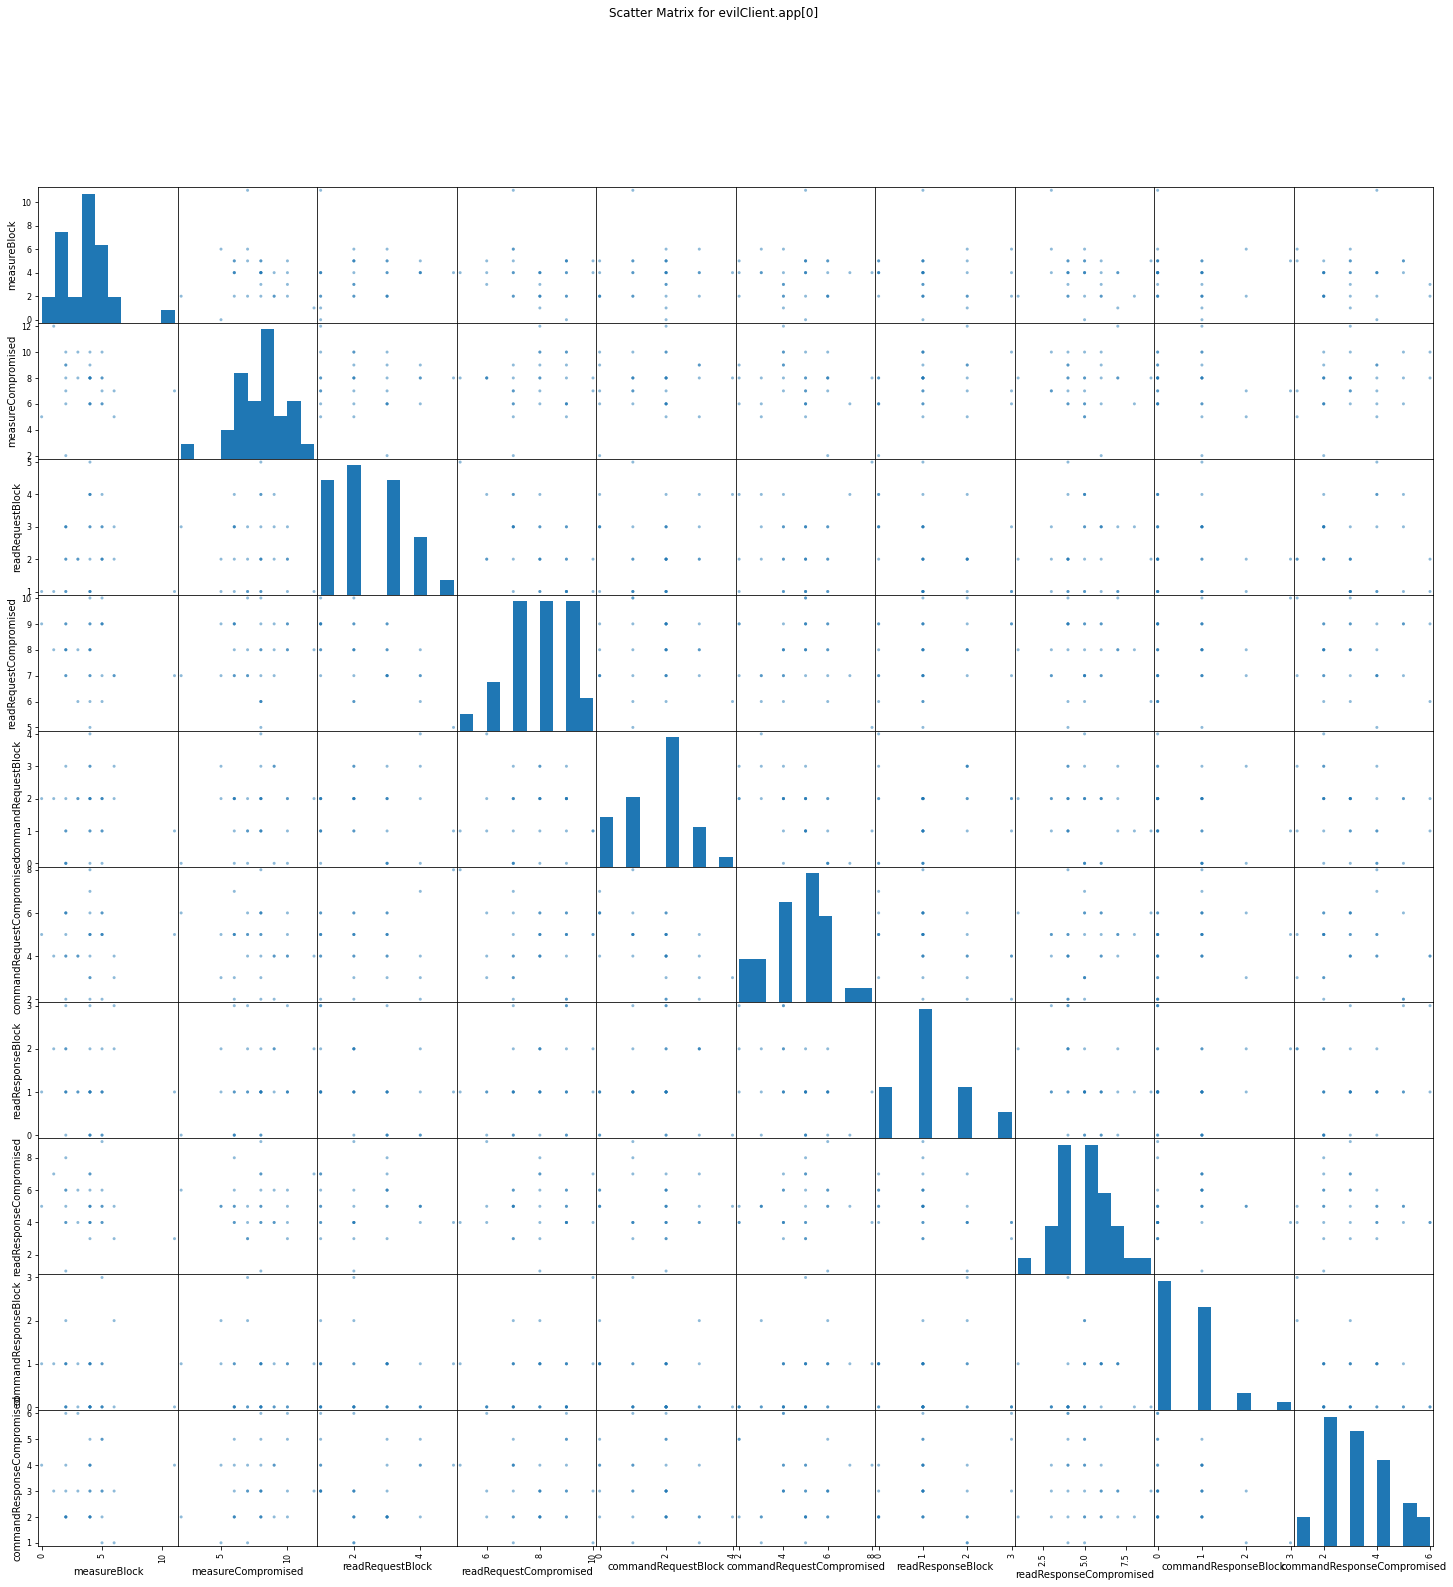

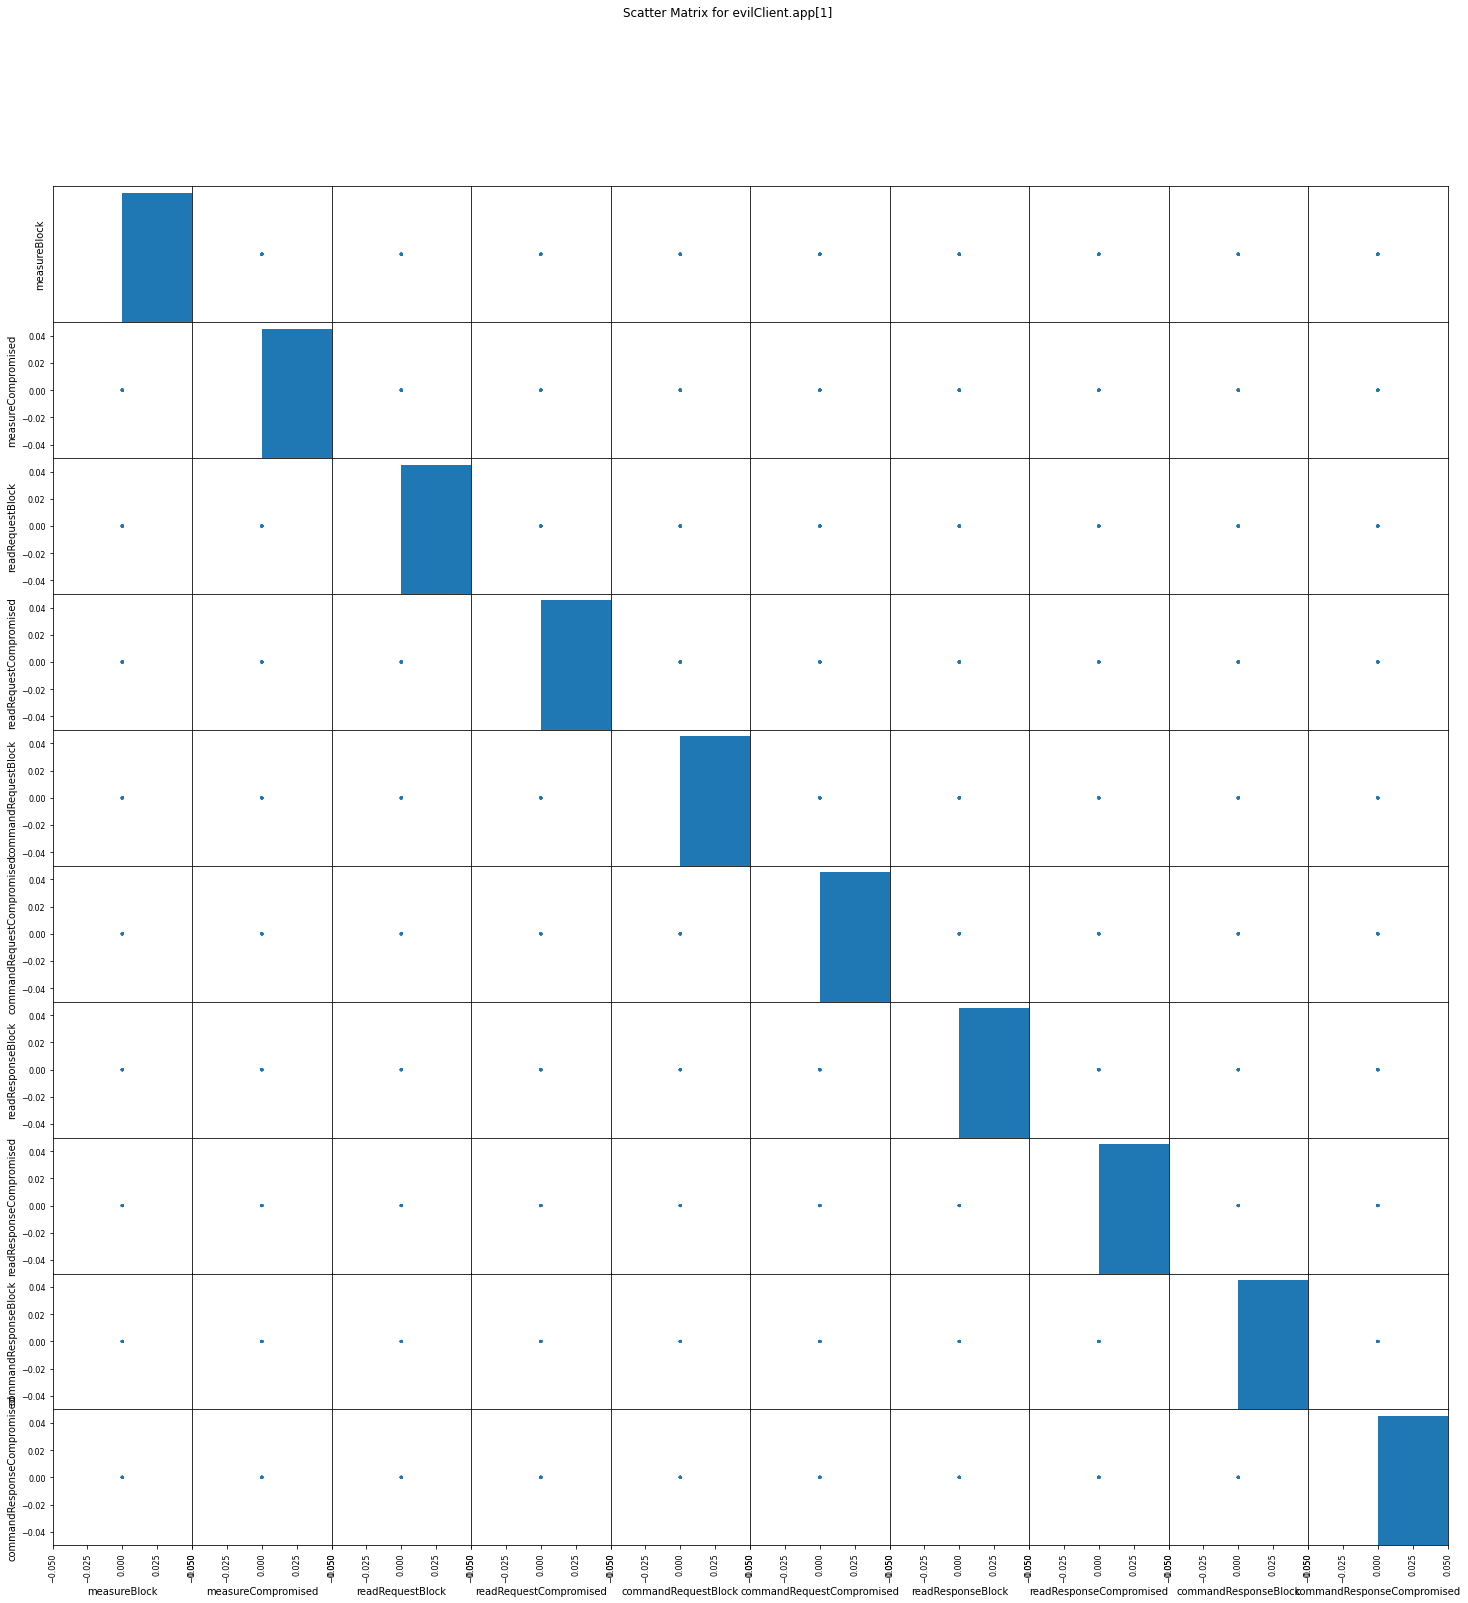

In [10]:
for j in range(numServers):
    df = evilScaDfList[j]
    print("## Data description for evilClient.app[" + str(j) + "] ##")
    print(df.describe())
    print("## Correlation Matrix ##")
    print(df.corr())
    pd.plotting.scatter_matrix(df, figsize=(25,25))
    plt.suptitle("Scatter Matrix for evilClient.app[" + str(j) + "]")

[(0, 15.0), (15.0, 30.0), (30.0, 45.0), (45.0, 60.0), (60.0, 75.0), (75.0, 90.0), (90.0, 105.0), (105.0, 120.0)]
[(0, 20.0), (20.0, 40.0), (40.0, 60.0), (60.0, 80.0), (80.0, 100.0), (100.0, 120.0)]
[]


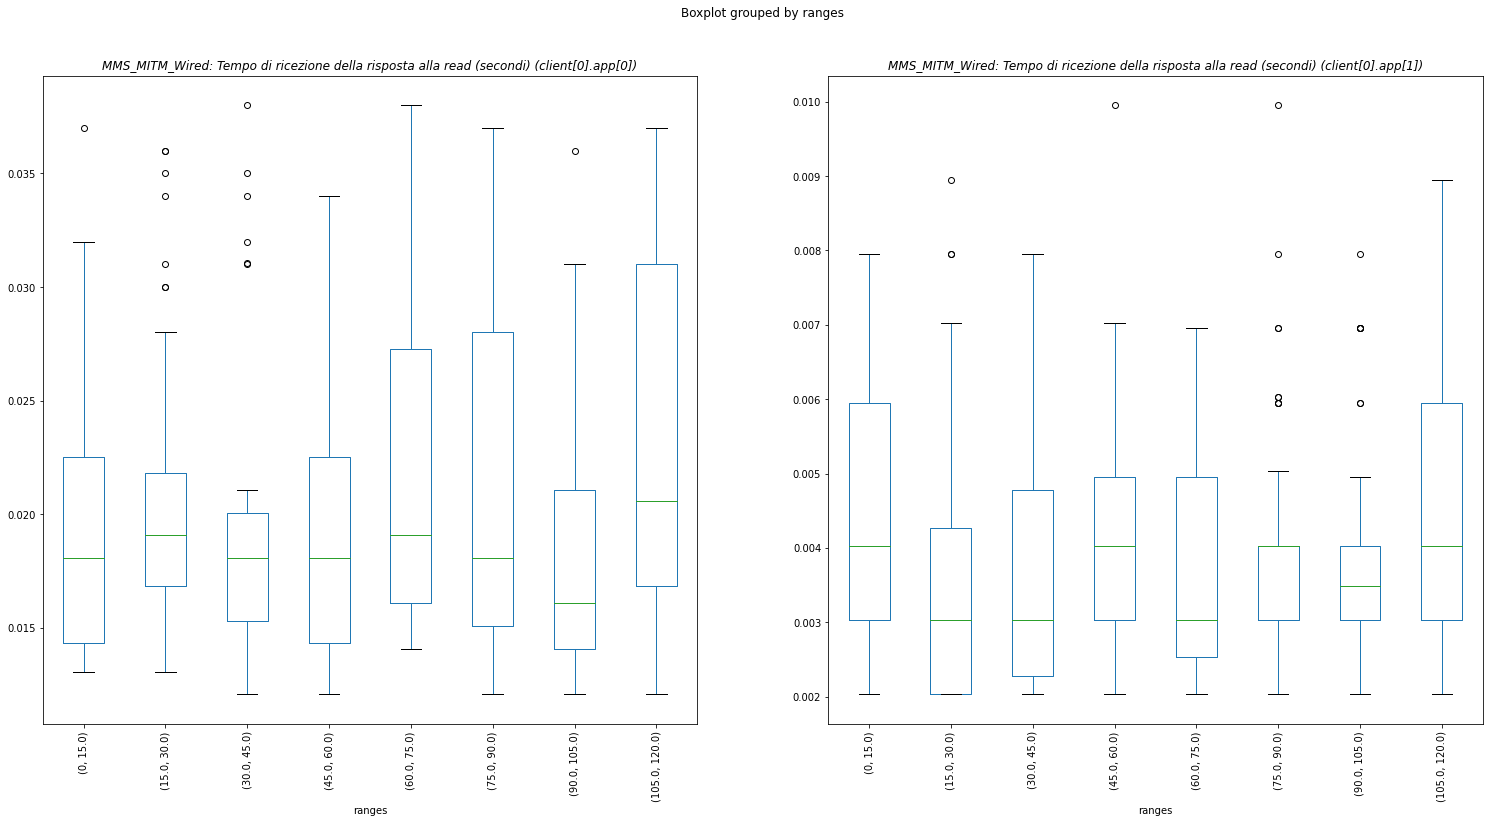

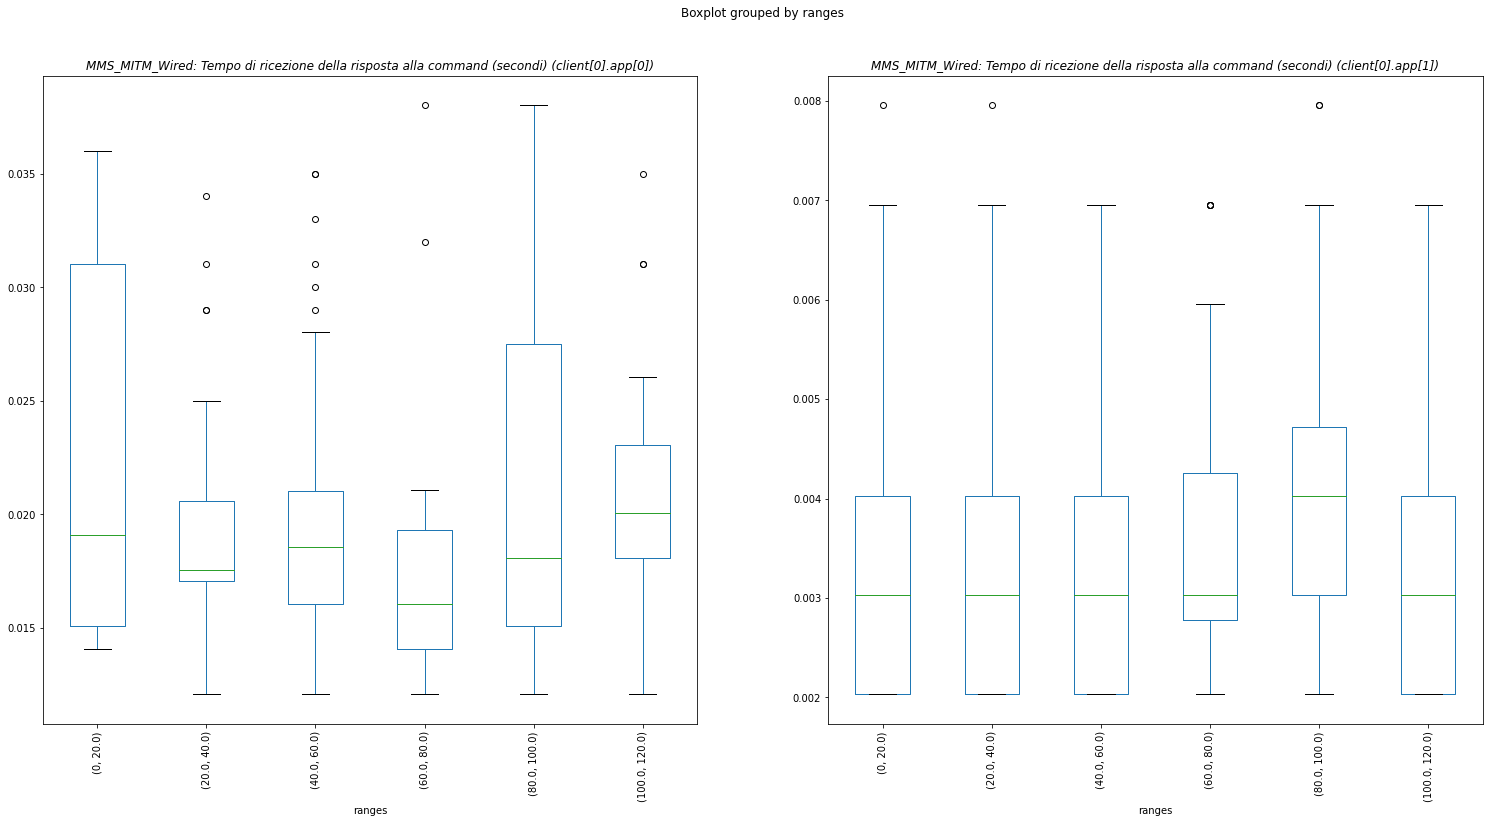

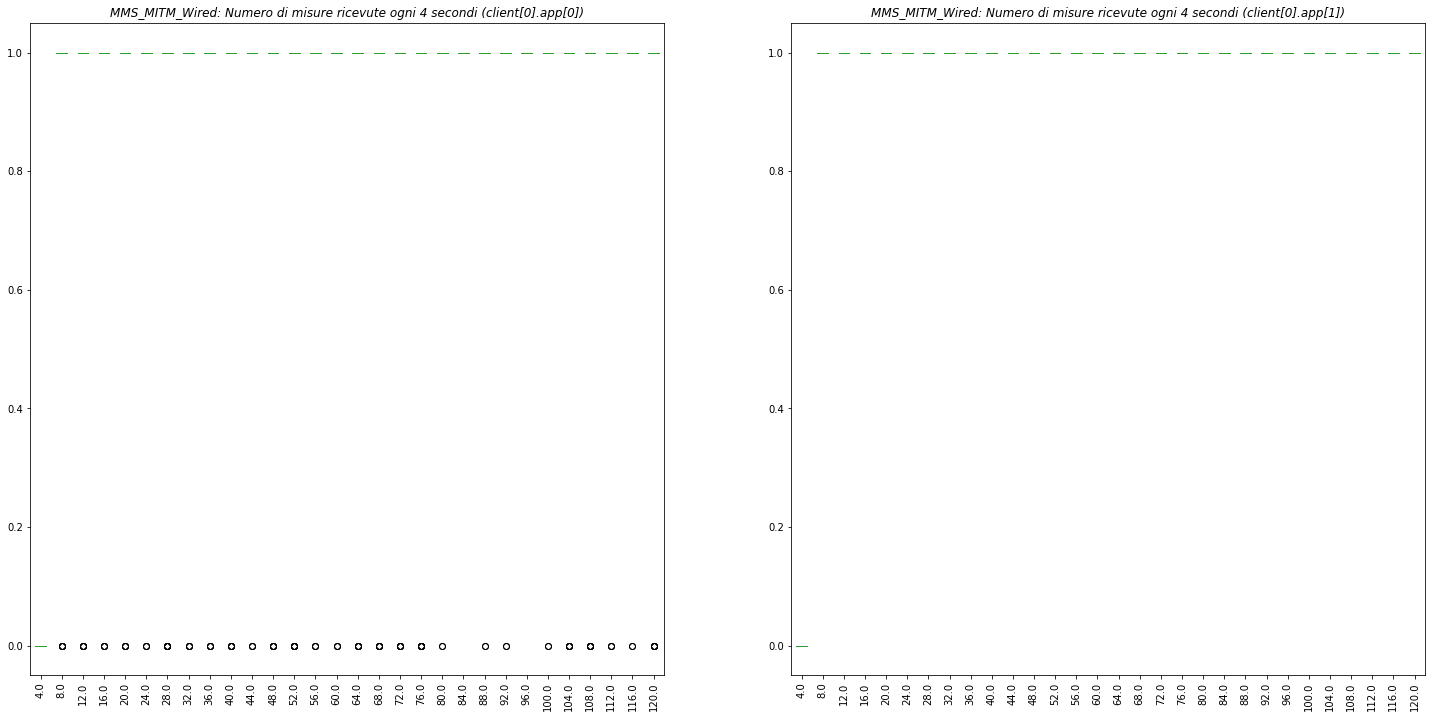

In [11]:
cliVecDfListReadTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read (secondi)", vecMeasName="readResponseReceivedTime", numRanges = 8)
cliVecDfListCommandTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command (secondi)", vecMeasName="commandResponseReceivedTime", numRanges = 6)
cliVecDfListMeasRec = plotBoxWiskerVec(numClients, numServers, title=simName + ": Numero di misure ricevute ogni 4 secondi", vecMeasName="measureReceivedAmount", numRanges = 0)

In [12]:
def plotPointsVec(numClients, numServers, title = "", cli = "client", vecMeasName = "measureReceivedAmount"):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(12*numClients)
    fig.set_figwidth(25)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            
            colPlot = pd.DataFrame(columns=["value", "time", "color"])
            rowNum = 0
            colors = cm.rainbow(np.linspace(0, 1, len(flt["runID"])))
            for row, color in zip(flt.itertuples(), colors):
                vecValue = pd.Series(row.vecvalue)
                vecTime = pd.Series(row.vectime)
                for val, time in zip(vecValue, vecTime):    
                    colPlot.loc[rowNum] = list((val, time, color))
                    rowNum += 1
                                
            outVec.append(colPlot)
            if DEBUG:
                colPlot.to_csv("./out.csv", mode="w", header=True)
            if numClients != 1:
                axes[i][j].scatter("time", "value", data=colPlot, c=colPlot["color"])
                axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                axes[j].scatter("time", "value", data=colPlot, c=colPlot["color"])
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')                    
    return outVec

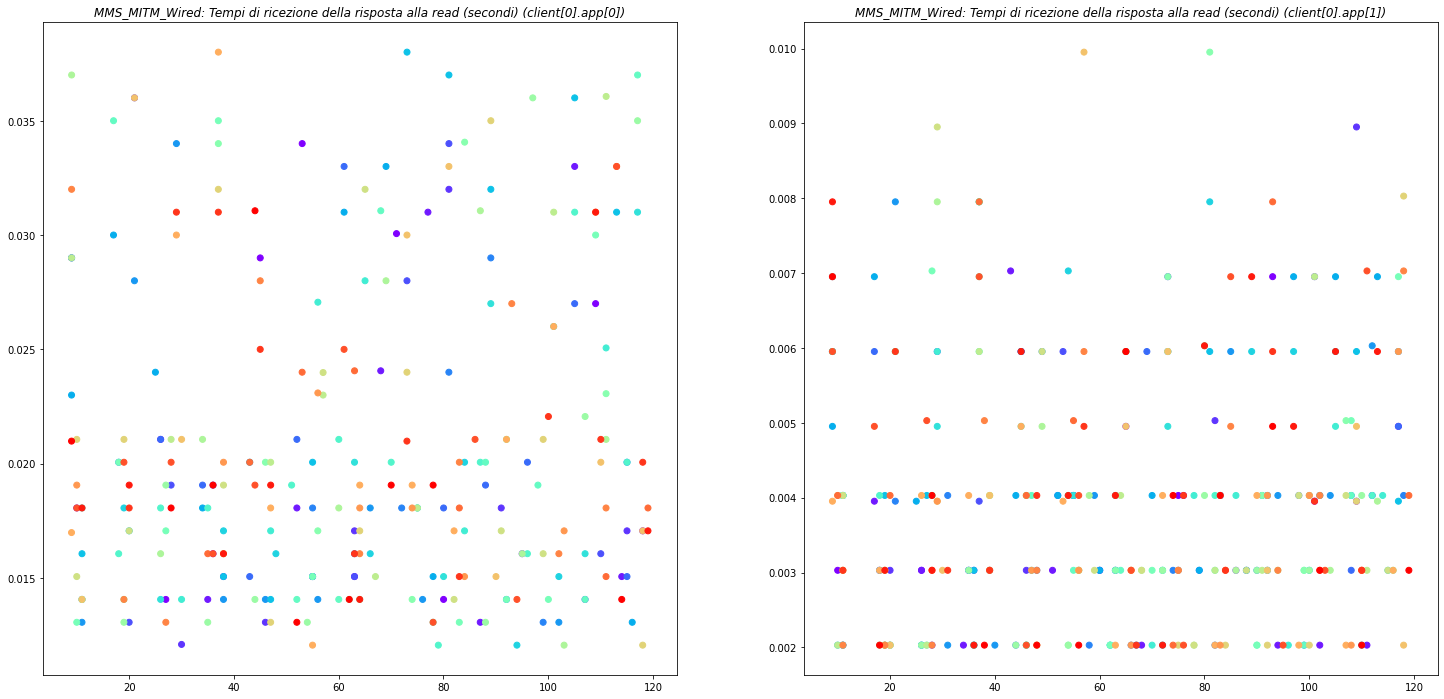

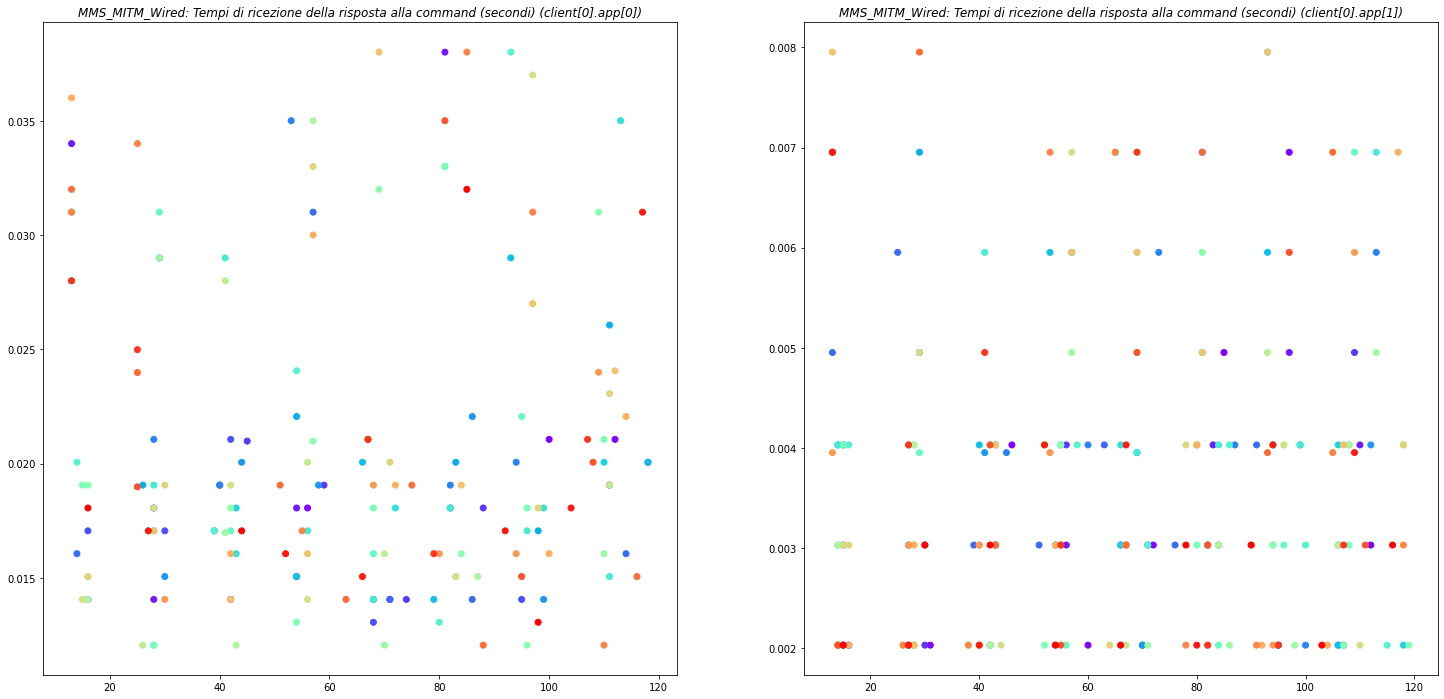

In [13]:
cliVecDfListReadTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempi di ricezione della risposta alla read (secondi)", vecMeasName="readResponseReceivedTime")
cliVecDfListCommandTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempi di ricezione della risposta alla command (secondi)", vecMeasName="commandResponseReceivedTime")

In [14]:
def confidenceInterval(data, confidence = 0.95):
    for (colName, colData) in data.iteritems():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        
        # m, m-h, m+h
        print("## Stat: " + colName)
        print("Average: " + str(m))
        print("Quantile: +-" + str(h)) 

Confidence interval for the different statistics

In [15]:
conf = 0.98
for i in range(numClients):
    for j in range(numServers):
        print("\n** " + simName + ": Confidence intervals for client[" + str(i) + "].app[" + str(j) + "] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(i+1)*j], conf)


** MMS_MITM_Wired: Confidence intervals for client[0].app[0] at 98.0%  **
## Stat: readSent
Average: 12.766666666666667
Quantile: +-0.19336795346308688
## Stat: commandSent
Average: 8.1
Quantile: +-0.13715576672167518
## Stat: readResponse
Average: 9.2
Quantile: +-0.5063561621275964
## Stat: commandResponse
Average: 5.833333333333333
Quantile: +-0.4734075931958596
## Stat: readResponseTimeout
Average: 3.5
Quantile: +-0.5505247123352748
## Stat: commandResponseTimeout
Average: 2.2666666666666666
Quantile: +-0.48575627194607335

** MMS_MITM_Wired: Confidence intervals for client[0].app[1] at 98.0%  **
## Stat: readSent
Average: 12.666666666666666
Quantile: +-0.21551949495052608
## Stat: commandSent
Average: 8.233333333333333
Quantile: +-0.19336795346308688
## Stat: readResponse
Average: 12.666666666666666
Quantile: +-0.21551949495052608
## Stat: commandResponse
Average: 8.233333333333333
Quantile: +-0.19336795346308688
## Stat: readResponseTimeout
Average: 0.0
Quantile: +-0.0
## Stat: c

In [16]:
for j in range(numServers):
    print("\n** " + simName + ": Confidence intervals for evilClient.app[" + str(j) + "] at " + str(conf*100) + "%  **")
    confidenceInterval(evilScaDfList[j], conf)


** MMS_MITM_Wired: Confidence intervals for evilClient.app[0] at 98.0%  **
## Stat: measureBlock
Average: 3.8
Quantile: +-0.902097774838929
## Stat: measureCompromised
Average: 7.566666666666666
Quantile: +-0.8808659054679134
## Stat: readRequestBlock
Average: 2.3666666666666667
Quantile: +-0.5075015066403075
## Stat: readRequestCompromised
Average: 7.833333333333333
Quantile: +-0.554727252045733
## Stat: commandRequestBlock
Average: 1.6333333333333333
Quantile: +-0.4644932634698001
## Stat: commandRequestCompromised
Average: 4.633333333333334
Quantile: +-0.6517460617261982
## Stat: readResponseBlock
Average: 1.2
Quantile: +-0.39856541777574733
## Stat: readResponseCompromised
Average: 5.0
Quantile: +-0.7371900953171028
## Stat: commandResponseBlock
Average: 0.6333333333333333
Quantile: +-0.3438194600818756
## Stat: commandResponseCompromised
Average: 3.1666666666666665
Quantile: +-0.6028770251109972

** MMS_MITM_Wired: Confidence intervals for evilClient.app[1] at 98.0%  **
## Stat: 